# Chroma Keying
1. Full green source image
1. Captured image with green background
    1. create mask by detecting green bg pixels using statistics of the green values. The area must be specified manually.
    1. create mask by background subtraction
1. video processing

* Project: take a vide and apply chroma keying

In [3]:
import os 
from pathlib import Path
import imageio 

import cv2 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

In [43]:
def imshow(imlist): # image show for cv2 BGR images
    import numpy 
    if type(imlist) == numpy.ndarray or len(imlist) == 1:
        if type(imlist) == numpy.ndarray:
            plt.imshow(imlist[:,:,::-1]); 
        else:
            plt.imshow(imlist[0][:,:,::-1]); 
        plt.axis(False);
    else:
        fig, axes = plt.subplots(1, len(imlist), figsize=(12,3))
        for ax, im in zip(axes, imlist):
            if len(im.shape) == 2:
                ax.imshow(im, cmap='gray')
            else:
                ax.imshow(im[:,:,::-1])  # opencv BGR -> RGB
            ax.set_axis_off()
    #

## Load green screen image
- this image is already processed to remove the background.

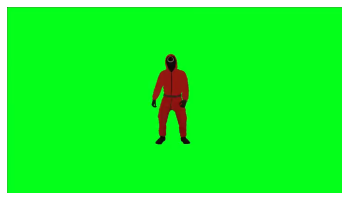

In [5]:
src_img = cv2.imread('pixels/squid_720x480_frame_0.png')
imshow(src_img)

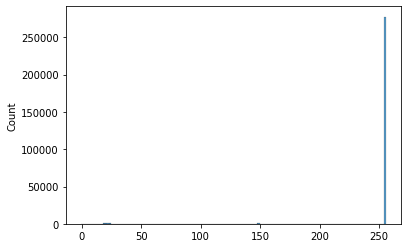

In [6]:
green_channel = src_img[:,:,1]
sns.histplot(green_channel.reshape(-1), discrete=True);

The most common green value is 255.


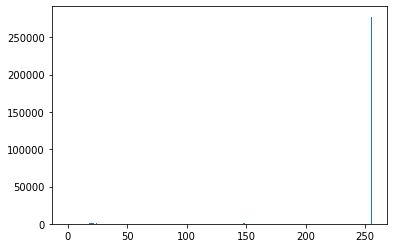

In [7]:
unique_values, counts = np.unique(green_channel.reshape(-1), return_counts=True)
plt.bar(unique_values, counts);
green_key = unique_values[np.argmax(counts)]
print(f"The most common green value is {green_key}.")

(400, 720, 3)


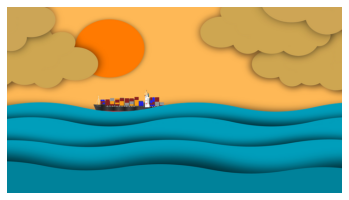

In [8]:
bg_img = cv2.imread('pixels/image-15.png')
bg_img = cv2.resize(bg_img, (src_img.shape[1], src_img.shape[0]))
print(bg_img.shape)
imshow(bg_img);

# Direct Overlay
- python was not born for the for-loops.

In [9]:
def chromaKeyGreen(in_array, keyvalue, bg=None):
    array = in_array.copy()
    if bg is None:
        print('@ chromaKeyGreen(): bg zero alloc.')
        bg = np.zeros_like(array, dtype="uint8")
    for r in range(array.shape[0]):
        for c in range(array.shape[1]):
            if array[r,c,1] == keyvalue:
                array[r,c] = bg[r,c]
    return array
#

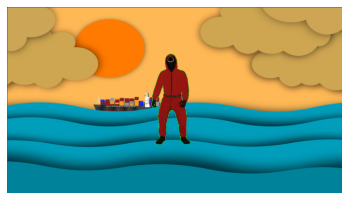

In [10]:
keyed = chromaKeyGreen(src_img, green_key, bg_img)
imshow(keyed)

@ chromaKeyGreen(): bg zero alloc.


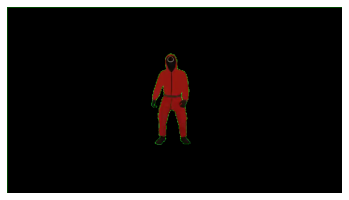

In [11]:
keyed_0 = chromaKeyGreen(src_img, green_key)
imshow(keyed_0)

# Hue analysis

- HSV in OpenCV: [Color Conversion](https://docs.opencv.org/3.4.15/de/d25/imgproc_color_conversions.html)

In [12]:
# hue in [0, 180]
hsv = cv2.cvtColor(src_img, cv2.COLOR_BGR2HSV)  
hsv.dtype

dtype('uint8')

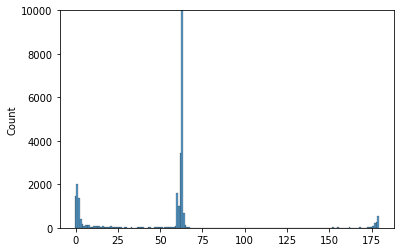

In [13]:
ax = sns.histplot(hsv[:,:,0].ravel(), discrete=True);
ax.set(ylim=[0,10000]);

- By calling `cv2.cvtColor()`, the HSV image returned is of uint8 type, which may contain any value [0, 255]. 
- Hue is represented by the rotation angle of the color circle, but [0, 360] may not be represented by 8 bits.
- So, instead of [0, 360] range, [0, 180] range is used.

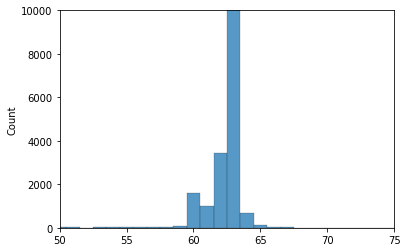

In [14]:
ax = sns.histplot(hsv[:,:,0].ravel(), discrete=True);
ax.set(ylim=[0,10000], xlim=[50, 75]);

In [15]:
def chromaKeyGreenRange(rgb_array, keyrange, bg=None):
    hsv = cv2.cvtColor(rgb_array, cv2.COLOR_BGR2HSV) 
    hue = hsv[:,:,0]
    array = rgb_array.copy()
    if bg is None:
        print('@ chromaKeyGreenRange(): bg zero alloc.')
        bg = np.zeros_like(array, dtype="uint8")
    for r in range(array.shape[0]):
        for c in range(array.shape[1]):
            if keyrange[0] <= hue[r,c] < keyrange[1]:
                array[r,c] = bg[r,c]
    return array
#

@ chromaKeyGreenRange(): bg zero alloc.


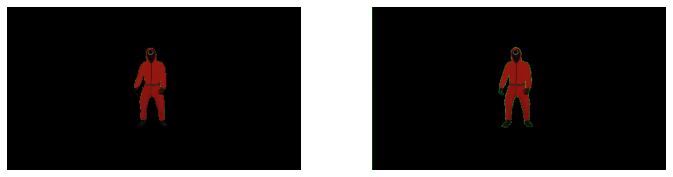

In [16]:
keyRange = [50, 70]
ii = chromaKeyGreenRange(src_img, keyRange)
imshow([ii, keyed_0])

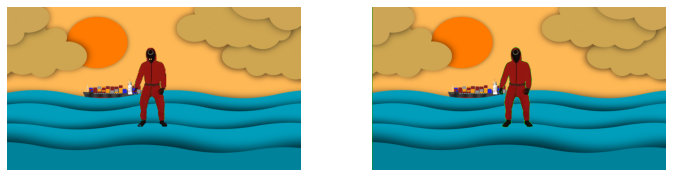

In [17]:
ii2 = chromaKeyGreenRange(src_img, keyRange, bg_img)
imshow([ii2, keyed])

Keeping the object well from killing the green zone has a trade-off.
- occlusion boundary pixels always contain some green component.

# Mask generation

(400, 720)


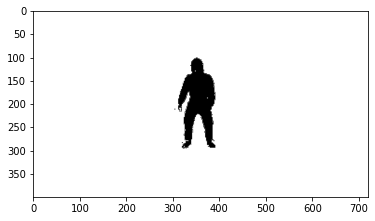

In [18]:
hsv = cv2.cvtColor(src_img, cv2.COLOR_BGR2HSV)  

mask = cv2.inRange(hsv[:,:,0], lowerb=60, upperb=70)
print(mask.shape)
plt.imshow(mask, cmap="gray");

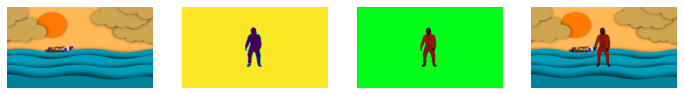

In [19]:
dest = bg_img.copy()
src  = src_img.copy()
composite = cv2.copyTo(dest, mask, src)
imshow([dest, np.expand_dims(mask, -1), src_img, composite])

In [20]:
# mask image
np.unique(mask.ravel()) # it has only two values

array([  0, 255], dtype=uint8)

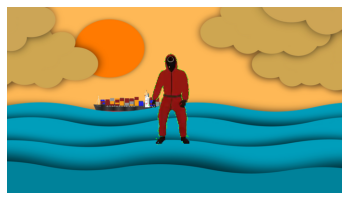

In [21]:
# numerical expression for the composit operation
mask3 = np.expand_dims(mask > 0, -1)            # create 0,1 boolean mask and expand the dimension for array broadcasting
comp = bg_img * mask3 + src_img * (1 - mask3)   # masking operation obtained by arithmetic operations
imshow(comp)

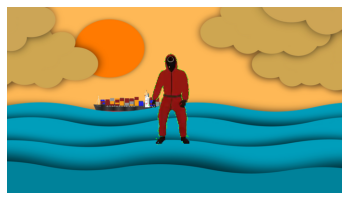

In [22]:
# numerical expression for the composit operation
mask4 = np.expand_dims(mask >> 7, -1)            # create 0,1 boolean mask and expand the dimension for array broadcasting
comp4 = bg_img *mask4 + src_img * (1 - mask4)   # masking operation obtained by arithmetic operations
imshow(comp4)

## A Real Photo taken in a chroma key studio

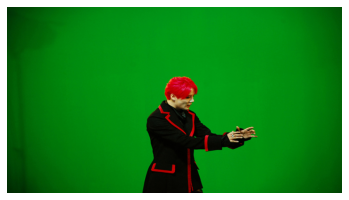

In [38]:
src_img = cv2.imread("pixels/140806_sayastudio2.png")
src_img = cv2.resize(src_img, (bg_img.shape[1], bg_img.shape[0]))
imshow(src_img)

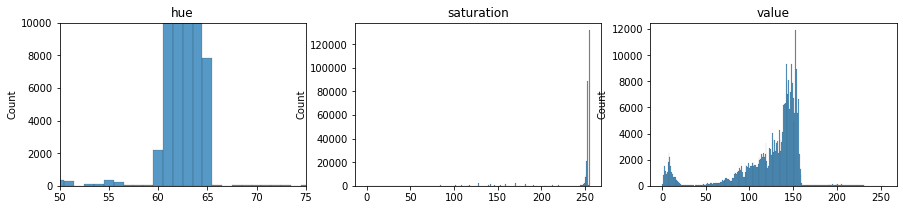

In [39]:
hsv = cv2.cvtColor(src_img, cv2.COLOR_BGR2HSV)
fig, axes = plt.subplots(1, 3, figsize=(15,3))
ax = sns.histplot(hsv[:,:,0].ravel(), discrete=True, ax=axes[0])
ax.set(xlim=[50, 75], ylim=[0, 10000], title='hue');
ax = sns.histplot(hsv[:,:,1].ravel(), discrete=True, ax=axes[1])
ax.set(title='saturation')
ax = sns.histplot(hsv[:,:,2].ravel(), discrete=True, ax=axes[2])
ax.set(title='value');

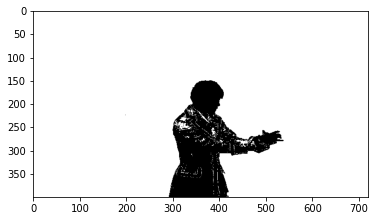

In [41]:
lowerb, upperb = 50, 70  # adjust the two values
mask1 = (lowerb < hsv[:,:,0]) & (hsv[:,:,0] < upperb) # hue only
plt.imshow(mask1, cmap='gray');

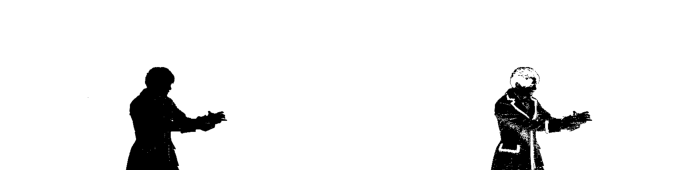

In [44]:
# saturation threshold
mask_sat = 230 < hsv[:,:,1]
mask2 = mask1 & mask_sat
# plt.imshow(mask2, cmap='gray');
imshow([mask2, mask_sat])

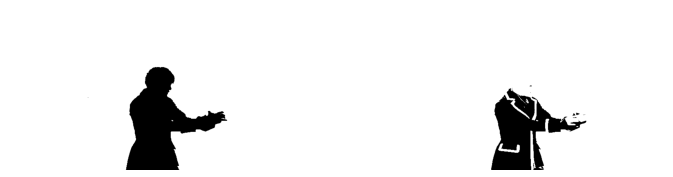

In [46]:
mask_val =  30 < hsv[:,:,2]
maskfinal = mask2 & mask_val
# plt.imshow(maskfinal, cmap='gray');
imshow([maskfinal, mask_val])

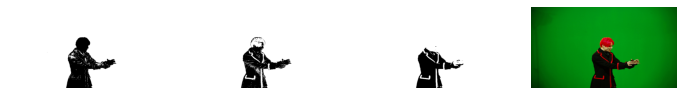

In [49]:
imshow([mask1, mask_sat, mask_val, src_img])

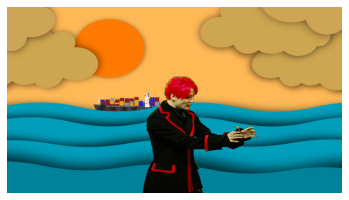

In [28]:
# numerical expression for the composit operation
maskfinal = maskfinal[:,:,np.newaxis]
comp = bg_img * maskfinal + src_img * (1 - maskfinal)
imshow(comp)

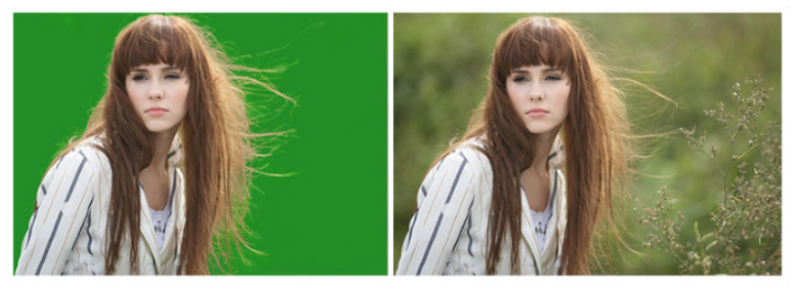

In [29]:
# https://deep-learning-study.tistory.com/134
example = imageio.imread("pixels/chromakey_example.png")

plt.figure(figsize=(14,7))
plt.imshow(example)
plt.axis(False);

# HSV vs RGB

(527, 800, 3) <class 'numpy.ndarray'>


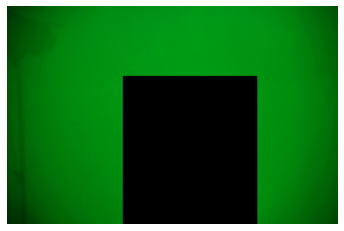

In [30]:
im_greenscreen = cv2.imread("pixels/140806_sayastudio2_bgmask.png")
print(im_greenscreen.shape, type(im_greenscreen))
imshow(im_greenscreen)

In [56]:
def imshow_channels(img, channel_name=["red", "green", "blue"]):
    fig, axes = plt.subplots(1, 3, figsize=(15,3))
    for i, ax in enumerate(axes):
        ax.imshow(img[:,:,i], cmap='gray')
        ax.set(title=channel_name[i])
#

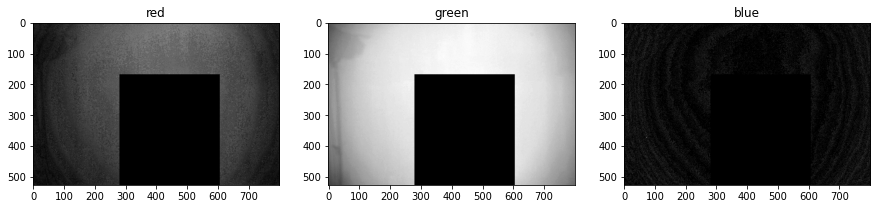

In [57]:
imshow_channels(im_greenscreen, channel_name=["red", "green", "blue"])

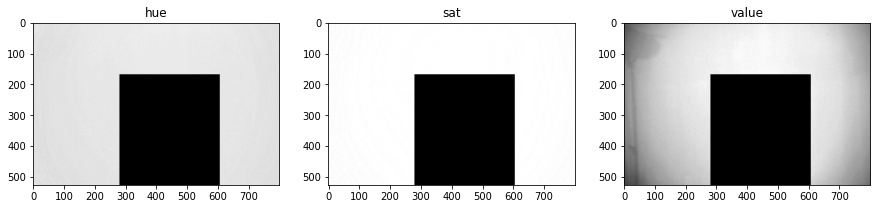

In [58]:
hsv_gs = cv2.cvtColor(im_greenscreen, cv2.COLOR_BGR2HSV)
imshow_channels(hsv_gs, channel_name = ["hue", "sat", "value"])

Let's simply try three 1D histogram analaysis.

In [33]:
def hist_hsv(hsv, bin0=0):
    ig, axes = plt.subplots(1, 3, figsize=(15,3))
    ax = sns.histplot(hsv[:,:,0].ravel(), discrete=True, ax=axes[0])
    ax.set(xlim=[0, 190], ylim=[0, 10000], title='hue');
    ax = sns.histplot(hsv[:,:,1].ravel(), discrete=True, ax=axes[1], binrange=[bin0, 255])
    ax.set(title='saturation')
    ax = sns.histplot(hsv[:,:,2].ravel(), discrete=True, ax=axes[2], binrange=[bin0, 255])
    ax.set(title='value');

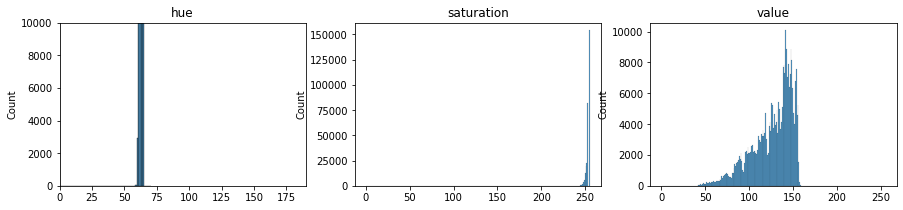

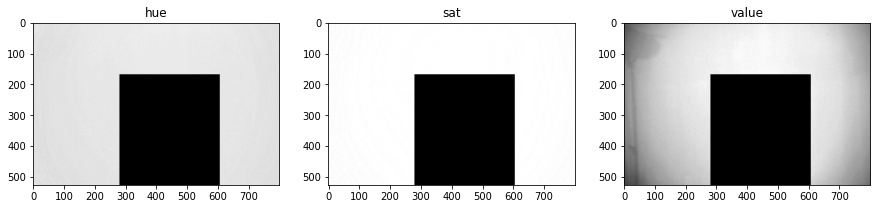

In [59]:
hsv_gs = cv2.cvtColor(im_greenscreen, cv2.COLOR_BGR2HSV)
hist_hsv(hsv_gs, bin0=1)
imshow_channels(hsv_gs, channel_name = ["hue", "sat", "value"])

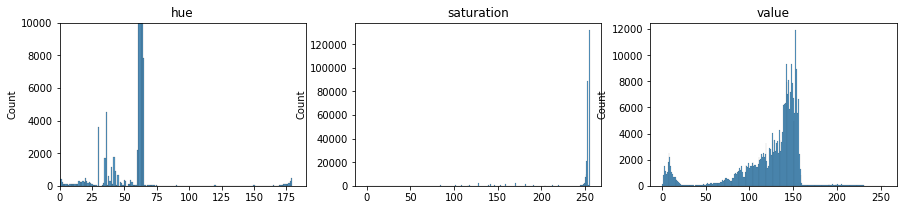

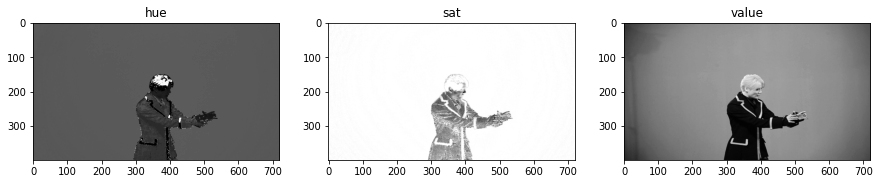

In [61]:
# hsv histogram of the original image including the foreground area
hsv = cv2.cvtColor(src_img, cv2.COLOR_BGR2HSV)
hist_hsv(hsv)
imshow_channels(hsv,channel_name = ["hue", "sat", "value"])

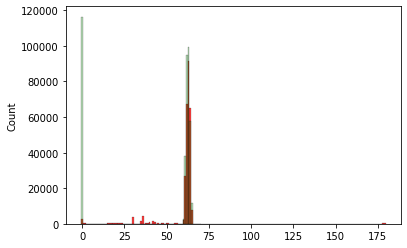

In [71]:
sns.histplot(hsv[:,:,0].reshape(-1), discrete=True, color='red')  # with foreground
sns.histplot(hsv_gs[:,:,0].reshape(-1), discrete=True, color="green", alpha=.3);  # without fg object

1. The two histograms show how to determine the thresholds for masking.
1. Foreground object must have a color distribution distinctively different from the green background.
1. Not only hue, but also saturation and value may also be useful to segment out the foreground.

# Segmentation by Background subtraction
1. We have a background image without any foreground subject.
    - This may be a simple image or a video.
    - In case of video, we can obtain a statistical model of the background (with Gaussian assumption)
    - In case of single image, we compare the magnitude of the difference between the input and the bg image.
1. Gaussian distribution model gives a statistical modeling of the problem.

End.